In [ ]:
import torch
from duckduckgo_search import DDGS
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from fastai.vision.widgets import *
torch.cuda.is_available()

True

In [4]:
def search_images(keywords, max_images=200): 
    return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

In [5]:
urls = search_images('chihuahua photos', max_images=1)
urls[0]

'https://www.zooplus.fr/magazine/wp-content/uploads/2018/09/chihuahua.jpg'

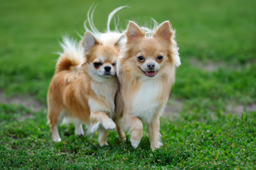

In [6]:
dest = 'data/chihuahua.jpg'
download_url(urls[0], dest)
im = Image.open(dest)
im.to_thumb(256, 256)

In [8]:
dog_breeds = [
    "Golden Retriever",
    "Dalmatian",
    "Pug",
    "Siberian Husky",
    "Dachshund",
    "Bulldog",
    "Poodle",
    "Chihuahua",
]
path = Path("data/dog_breeds")

for o in dog_breeds:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

38

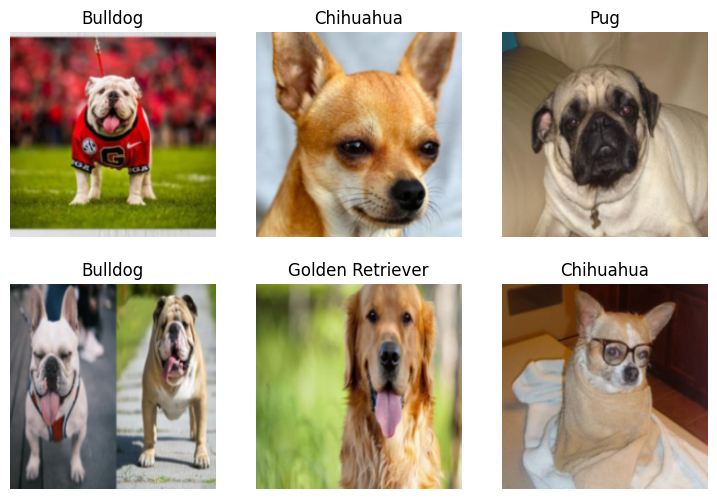

In [19]:
dls = DataBlock(blocks=(ImageBlock, CategoryBlock),
                get_items = get_image_files,
                splitter = RandomSplitter(valid_pct=0.2, seed=42),
                get_y = parent_label,
                item_tfms = [Resize(224, method='squish'), RandomResizedCrop(224, min_scale=0.8)]).dataloaders(path, bs=64)

dls.show_batch(max_n=6)

In [21]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(2)

epoch,train_loss,valid_loss,accuracy,time
0,1.594424,0.135594,0.956376,00:20


epoch,train_loss,valid_loss,accuracy,time
0,0.209364,0.114866,0.963087,00:26
1,0.140243,0.076912,0.973154,00:27


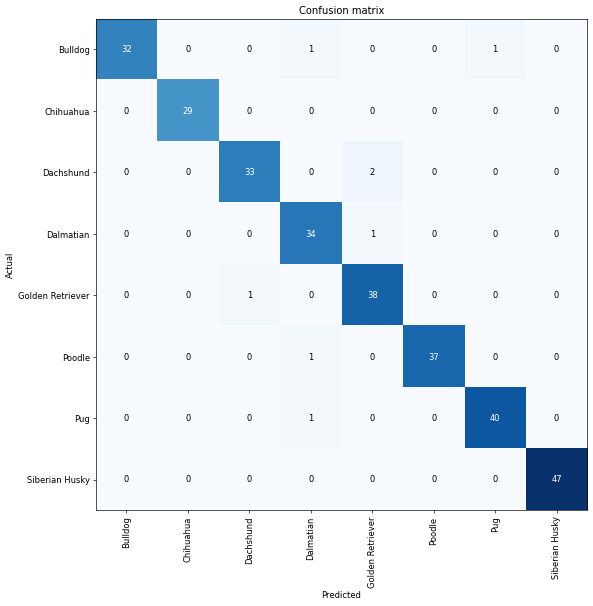

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)

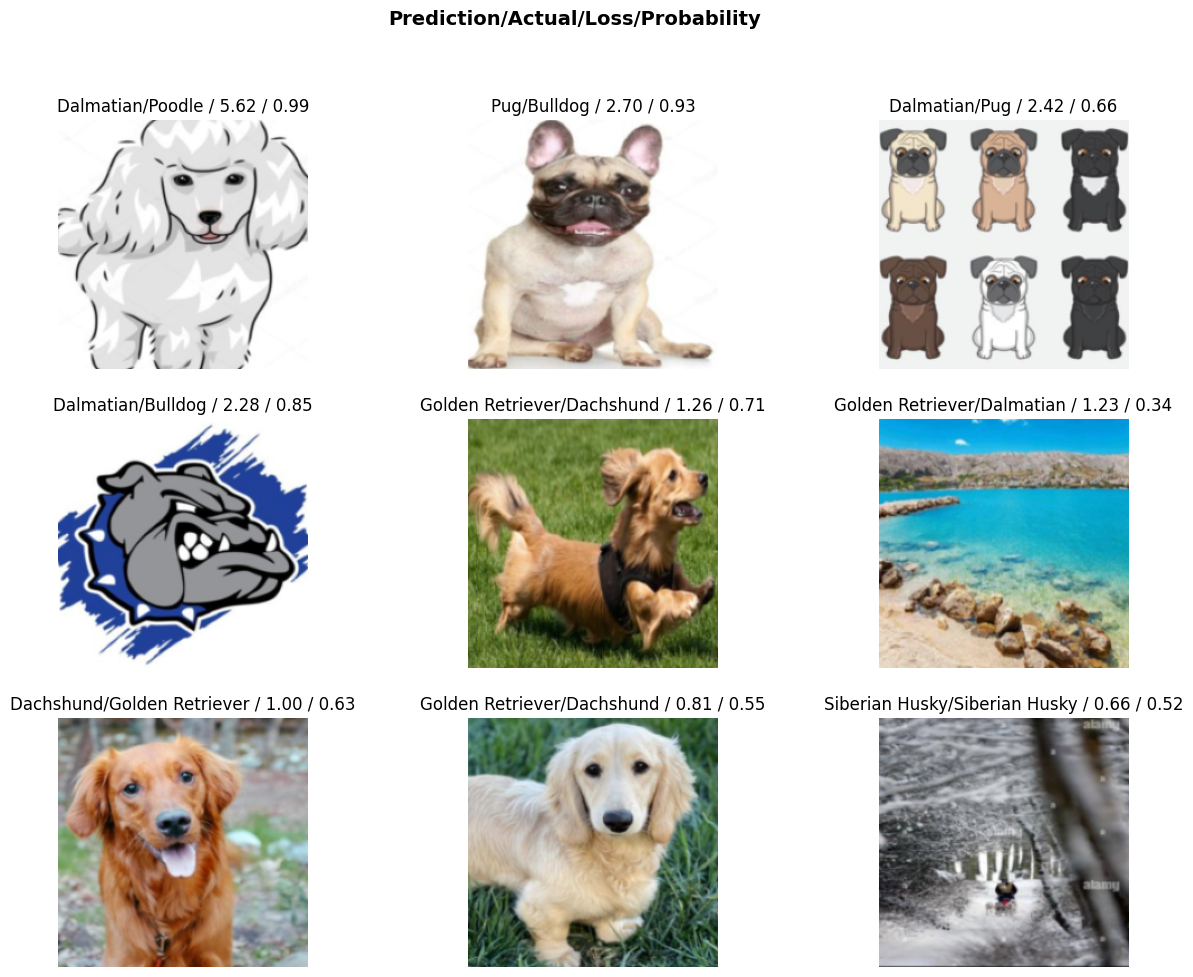

In [23]:
interp.plot_top_losses(9, figsize=(15,11))

In [31]:
cleaner = ImageClassifierCleaner(learn)
cleaner

: 

: 